In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_images(img1,img2,title1="",title2="",figure_size = [15,15]):
    fig = plt.figure(figsize=figure_size)
    axis1 = fig.add_subplot(1,2,1)
    axis1.set(xticks=[],yticks=[],title=title1)
    axis1.imshow(img1,cmap="gray")

    axis2 = fig.add_subplot(1,2,2)
    axis2.set(xticks=[],yticks=[],title=title2)
    axis2.imshow(img2,cmap="gray")



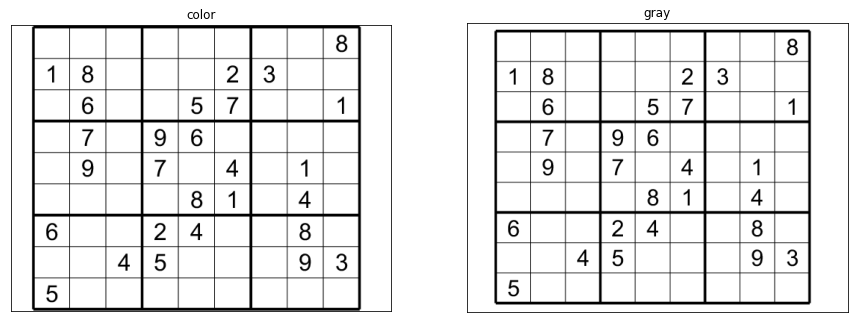

In [3]:
img = cv2.imread("./datasets/sudoku_digital3.png")
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray_img = cv2.copyMakeBorder(gray_img.copy(),10,10,10,10,cv2.BORDER_CONSTANT,value=[255,255,255])
plot_images(img,gray_img,"color","gray")

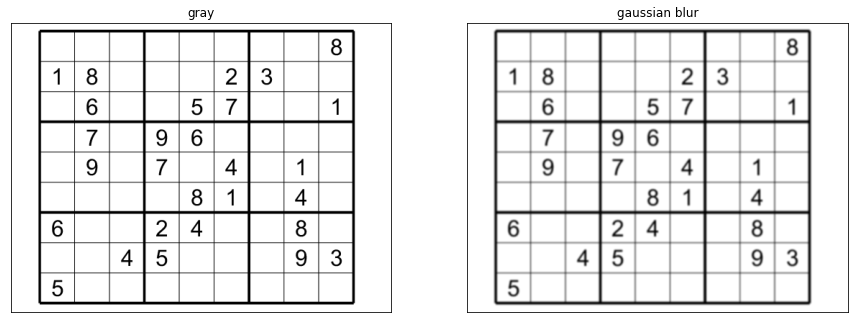

In [4]:
blurred_img = cv2.GaussianBlur(gray_img,(5,5),0)

plot_images(gray_img,blurred_img,"gray","gaussian blur")

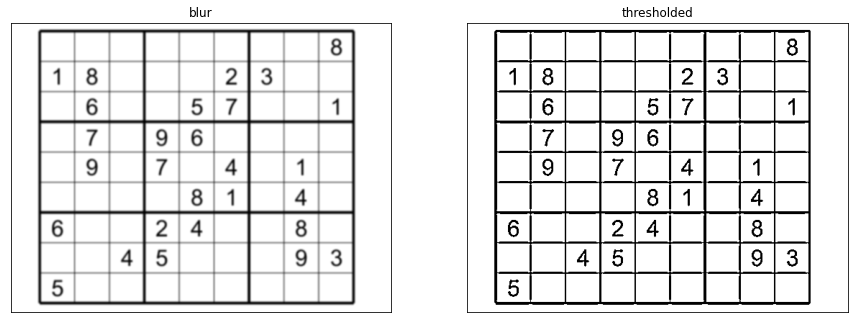

In [5]:
thresh_image = cv2.adaptiveThreshold(blurred_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,5,2)
plot_images(blurred_img,thresh_image,"blur","thresholded")

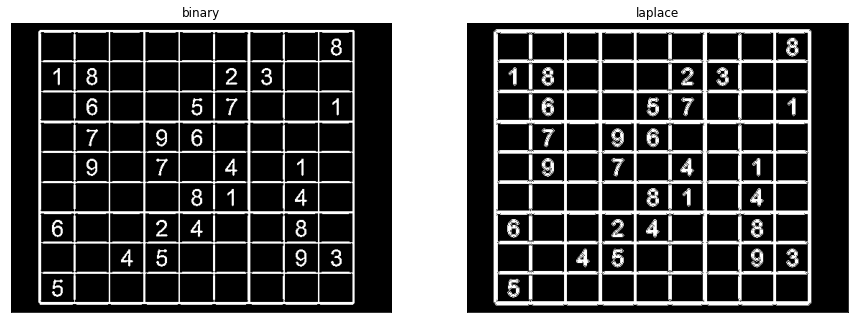

In [6]:
inverted_img = cv2.bitwise_not(thresh_image)
laplace_kernel = np.array([[0,1,0],[1,-2,1],[0,1,0]],np.int)

laplace_img = cv2.filter2D(inverted_img,-1,laplace_kernel)
plot_images(inverted_img,laplace_img,"binary","laplace")

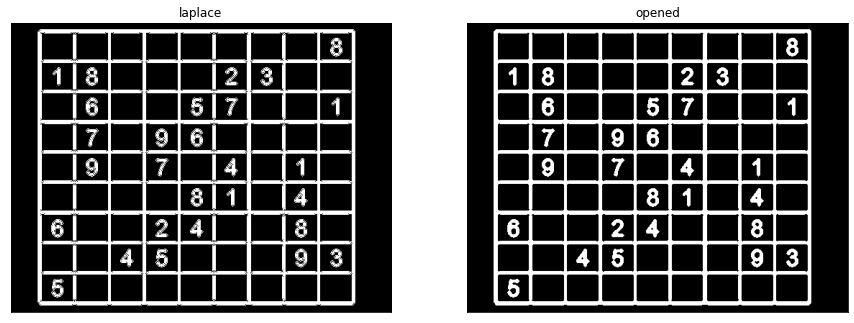

In [10]:
# erode_kernel = np.ones((3,3),np.uint8)
erode_kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
#erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
# eroded_img = cv2.erode(laplace_img,erode_kernel,iterations = 1)
opened_img = cv2.morphologyEx(laplace_img,cv2.MORPH_CLOSE,erode_kernel)
plot_images(laplace_img,opened_img,"laplace","opened")

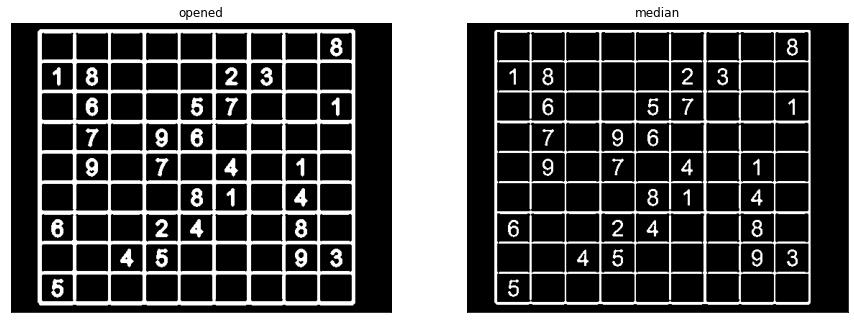

In [11]:
median_img = cv2.medianBlur(inverted_img,3)
plot_images(opened_img,median_img,"opened","median")

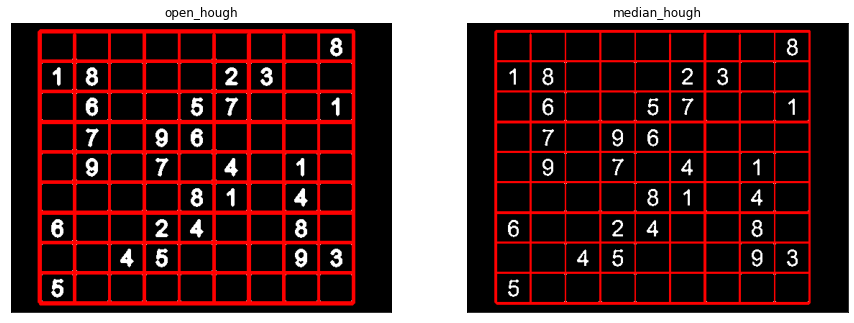

In [12]:
#testing hough lines with opened and median image, hough lines added to reinforce the lines by adding them on the original image

open_hough_lines = cv2.HoughLinesP(opened_img,1,np.pi/180,100,minLineLength=100,maxLineGap=10)
median_hough_lines = cv2.HoughLinesP(median_img,1,np.pi/180,100,minLineLength=100,maxLineGap=10)

open_hough_image = cv2.cvtColor(opened_img.copy(),cv2.COLOR_GRAY2BGR)
for line in open_hough_lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(open_hough_image,(x1,y1),(x2,y2),(255,0,0),1)

median_hough_image = cv2.cvtColor(median_img.copy(),cv2.COLOR_GRAY2BGR)
for line in median_hough_lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(median_hough_image,(x1,y1),(x2,y2),(255,0,0),1)

plot_images(open_hough_image,median_hough_image,"open_hough","median_hough")

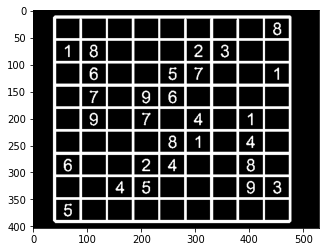

In [13]:
#selecting the median_hough image
median_hough_image = cv2.cvtColor(median_img.copy(),cv2.COLOR_GRAY2BGR)
for line in median_hough_lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(median_hough_image,(x1,y1),(x2,y2),(255,255,255),2)

median_hough_image = cv2.cvtColor(median_hough_image,cv2.COLOR_BGR2GRAY)
plt.imshow(median_hough_image,cmap="gray")

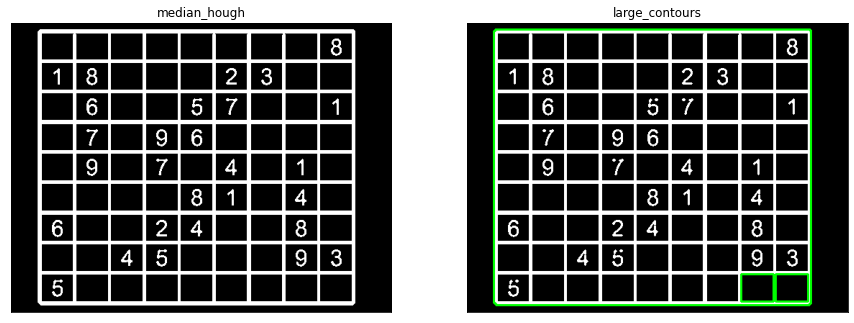

In [14]:
erode_kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
#erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
#eroded_img = cv2.erode(median_hough_image,erode_kernel,iterations = 1)
eroded_image = cv2.morphologyEx(median_hough_image,cv2.MORPH_OPEN,erode_kernel)

contours,_ = cv2.findContours(eroded_image.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
large_contours = sorted(contours,key=cv2.contourArea,reverse=True)[:3]

contour_img = cv2.drawContours(cv2.cvtColor(eroded_image.copy(),cv2.COLOR_GRAY2BGR),large_contours,-1,(0,255,0),2)
plot_images(median_hough_image,contour_img,"median_hough","large_contours")
#retireve largest contour

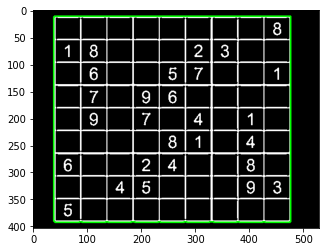

In [15]:

#so the hough transform is adding unnecessary horizontal lines, so its better to apply the contour first on the inverted threshold and then extract the largest shape by subtracting it from the background

contours,_ = cv2.findContours(median_img.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
large_contours = sorted(contours,key=cv2.contourArea,reverse=True)[:1]

contour_img = cv2.drawContours(cv2.cvtColor(median_img.copy(),cv2.COLOR_GRAY2BGR),large_contours,-1,(0,255,0),2)
plt.imshow(contour_img,cmap="gray")

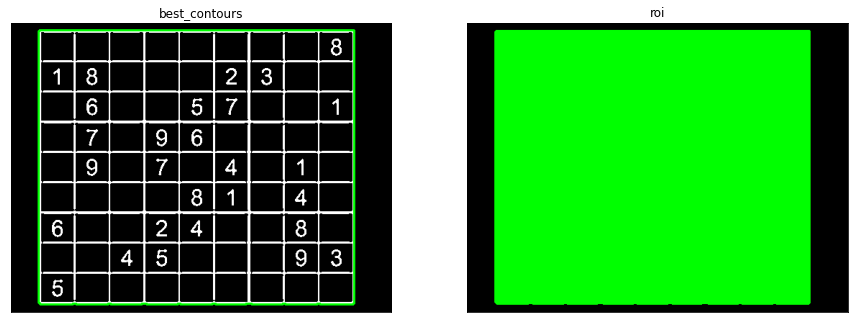

In [16]:

roi_image = cv2.cvtColor(median_img.copy(),cv2.COLOR_GRAY2BGR)
roi_contour = None
for c in large_contours:
    perimeter = cv2.arcLength(c,True)
    sides = cv2.approxPolyDP(c,0.02*perimeter,True)
    if len(sides) == 4:
        roi_contour = c
        cv2.drawContours(roi_image,[c],0,(0,255,0),thickness=cv2.FILLED)
        break

plot_images(contour_img,roi_image,"best_contours","roi")

(403, 530)


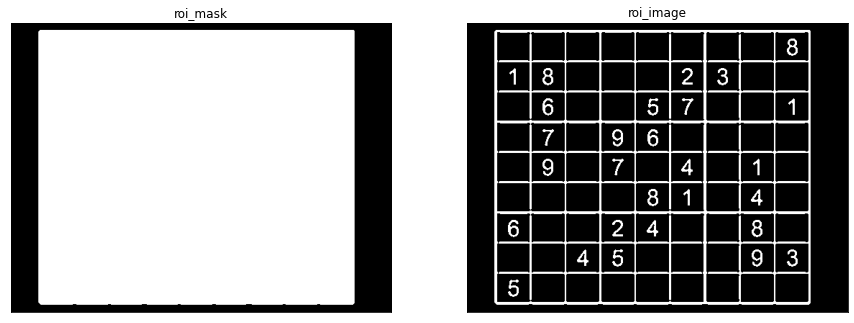

In [17]:
print(median_img.shape)
roi_mask = np.zeros(median_img.shape,np.uint8)
cv2.drawContours(roi_mask,[roi_contour],0,1,-1)

roi_image = cv2.bitwise_and(median_img,median_img,mask=roi_mask)

plot_images(roi_mask,roi_image,"roi_mask","roi_image")


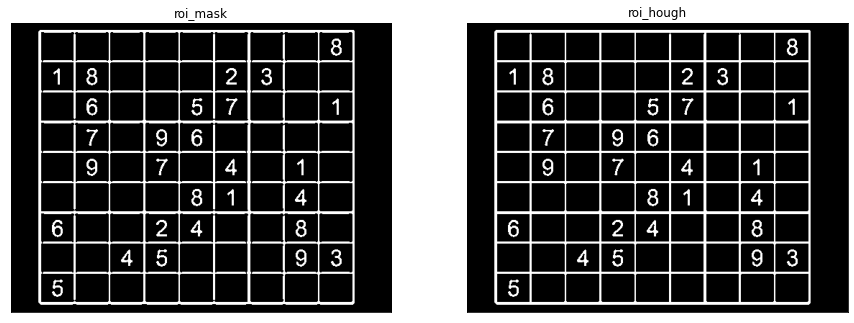

In [18]:
#trying to fix / smoothing the edges by overlaying the hough lines on the edges -> did not work but can be used to complete the lines

# bounding_box = np.zeros(roi_mask.shape,np.uint8)
# cv2.drawContours(bounding_box,[roi_contour],0,1,1)
#plt.imshow(bounding_box,cmap="gray")

roi_hough_lines = cv2.HoughLinesP(roi_image,1,np.pi/180,100,minLineLength=100,maxLineGap=15)
roi_hough_image = cv2.cvtColor(roi_image,cv2.COLOR_GRAY2BGR)
# plt.imshow(roi_hough_img,cmap="gray")
for line in roi_hough_lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(roi_hough_image,(x1,y1),(x2,y2),(255,255,255),1)

plot_images(roi_image,roi_hough_image,"roi_mask","roi_hough")

max 9.007813e-10
[9.007813e-10]


(array([13], dtype=int64), array([475], dtype=int64))

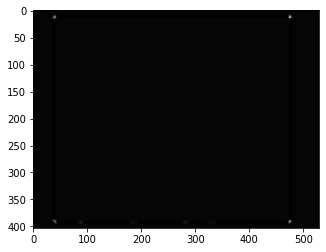

In [19]:
#detect the corners on the mask
corners = None
# smooth_edge_image = cv2.medianBlur(bounding_box,3)
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(roi_mask, cv2.MORPH_CLOSE, kernel)
corner_image = cv2.cornerHarris(opening,7,5,0.01)
plt.imshow(corner_image,cmap="gray")
max_corner_intensity = corner_image.max()
print("max",max_corner_intensity)
print(corner_image[corner_image > 0.90*max_corner_intensity])

corners = np.where(corner_image > 0.85* max_corner_intensity)
corners

#difficulty in processing results using Harris, multiple corners being detected

[476  12 475 392  41 392  38  13]


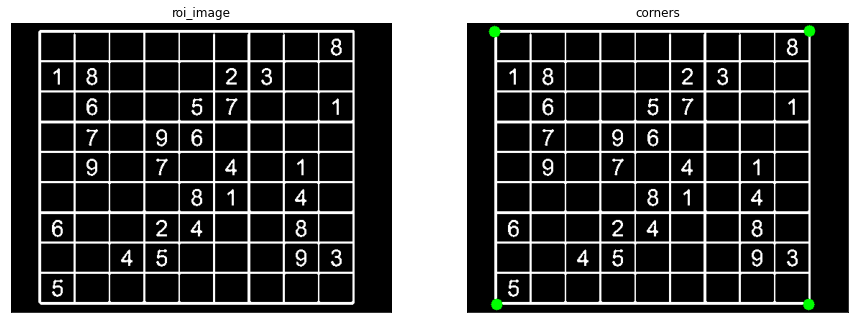

In [20]:
#corners using Shi Tomasi as it allows specifying the minimum distance between corners
corners = cv2.goodFeaturesToTrack(roi_mask,4,0.01,25)
corners = np.int0(corners)
print(corners.ravel())

# corner_image = cv2.cvtColor(roi_hough_image,cv2.COLOR_GRAY2BGR)
corner_image = roi_hough_image.copy()
for corner in corners:
    x,y = corner.ravel()
    cv2.circle(corner_image,(x,y),8,(0,255,0),-1)

plot_images(roi_hough_image,corner_image,"roi_image","corners")

In [21]:
img_width,img_height = 500,500
img_width,img_height

unwrap_corner_points = [[0,0],[img_width,0],[0,img_height],[img_width,img_height]]

corner_points = [[corner.ravel()[0],corner.ravel()[1]] for corner in corners]
print(corner_points)
#find points closest to each corner for the perspective transform
original_corner_points = []
for ucp in unwrap_corner_points:
     min_manhattan_dist = list(map(lambda point: abs(point[0] - ucp[0]) + abs(point[1] - ucp[1])  ,corner_points))
     original_corner_points.append(corner_points[min_manhattan_dist.index(min(min_manhattan_dist))])

original_corner_points

[[476, 12], [475, 392], [41, 392], [38, 13]]


[[38, 13], [476, 12], [41, 392], [475, 392]]

(403, 530) (500, 500, 3)


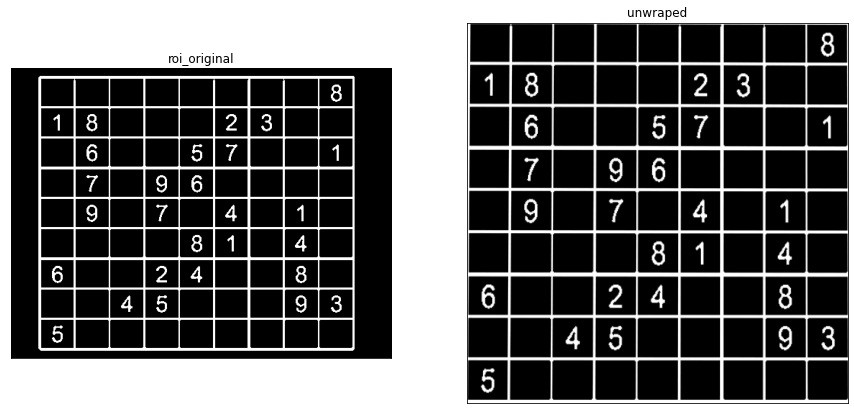

In [22]:
#perspective transform
unwrap_corner_points = np.float32(unwrap_corner_points)
original_corner_points = np.float32(original_corner_points)
transform_matrix = cv2.getPerspectiveTransform(original_corner_points,unwrap_corner_points)

unwraped_image = cv2.warpPerspective(roi_hough_image,transform_matrix,(500,500))
print(roi_mask.shape,unwraped_image.shape)
plot_images(roi_hough_image,unwraped_image,"roi_original","unwraped")
#plt.imshow(unwraped_image,cmap="gray")

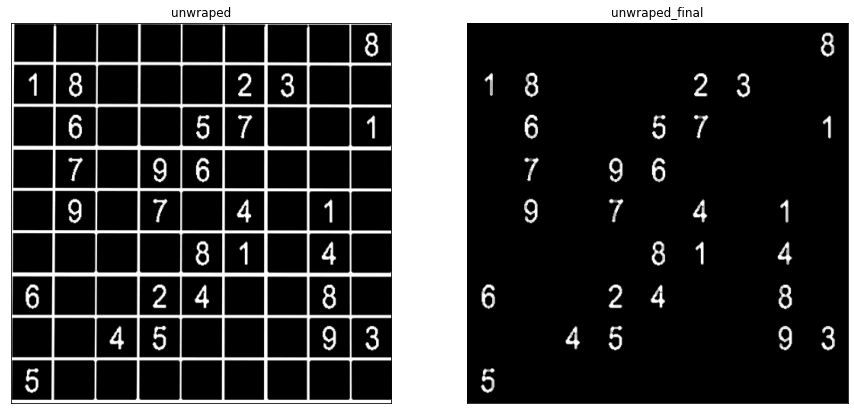

In [23]:
#trying to remove the lines using houhg transform
unwrap_hough_lines = cv2.HoughLinesP(cv2.cvtColor(unwraped_image,cv2.COLOR_BGR2GRAY),1,np.pi/180,100,minLineLength=150,maxLineGap=20)
#roi_hough_image = cv2.cvtColor(roi_image,cv2.COLOR_GRAY2BGR)
unwrap_final = unwraped_image.copy()
# plt.imshow(roi_hough_img,cmap="gray")
for line in unwrap_hough_lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(unwrap_final,(x1,y1),(x2,y2),(0,0,0),3)

#unwrap_final = cv2.medianBlur(unwrap_final.copy(),5)
erode_kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
dilate_kernel = np.ones((5,5),np.uint8)
# unwrap_final = cv2.morphologyEx(unwrap_final, cv2.MORPH_OPEN, kernel)
unwrap_final = cv2.morphologyEx(unwrap_final, cv2.MORPH_OPEN, erode_kernel)
#unwrap_final = cv2.erode(unwrap_final.copy(),erode_kernel,iterations=1)
#unwrap_final = cv2.dilate(unwrap_final.copy(),erode_kernel,iterations=1)
#unwrap_final = cv2.morphologyEx(unwrap_final, cv2.MORPH_CLOSE, dilate_kernel)
plot_images(unwraped_image,unwrap_final,"unwraped","unwraped_final")

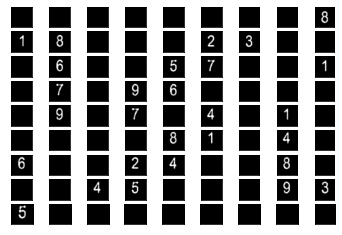

In [24]:
unwrap_final = cv2.resize(unwrap_final,(500,500))
# plt.imshow(unwraped_image,cmap="gray")

imgheight=unwrap_final.shape[0]
imgwidth=unwrap_final.shape[1]

box_size = imgheight//9 + 1

number_tiles = []

for y in range(0,imgheight,box_size):
    for x in range(0,imgwidth,box_size):
        tile = unwrap_final[y:y+box_size,x:x+box_size].copy()
        # print(tile.shape)
        number_tiles.append(tile)

#number_tiles = np.array(number_tiles,np.uint8)
# np.shape(number_tiles)
def print_num_grid(rows,cols,img_tiles):

    splited_figures = plt.figure()
    axes = [splited_figures.add_subplot(rows,cols,r*rows+c + 1) for r in range(rows) for c in range(cols)]

    for i,ax in enumerate(axes):
        ax.imshow(img_tiles[i],cmap="gray")
        ax.set(xticks=[],yticks=[])

print_num_grid(9,9,number_tiles)


In [36]:
#extract one number to deal with it
cv2.imwrite("no9.png",number_tiles[9])
number_tiles[11].shape

(56, 56, 3)

In [30]:
number_img = cv2.imread("no6.png",0)
number_img = cv2.resize(number_img,(30,30))
plt.imshow(number_img,cmap="gray")
number_img.shape

error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-9d_dfo3_\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


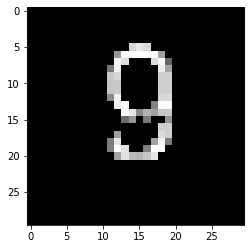

In [309]:
#number_img = cv2.medianBlur(number_img,1)
_,thresh_number = cv2.threshold(number_img,100,255,cv2.THRESH_TOZERO)
# kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
# thresh_number = cv2.erode(thresh_number,kernel,iterations=1)
# thresh_number = cv2.morphologyEx(thresh_number,cv2.MORPH_CLOSE,kernel)
# p = cv2.GaussianBlur(thresh_number,(3,3),0)
plt.imshow(thresh_number,cmap="gray")

(30, 30)
2
15 15
77.0


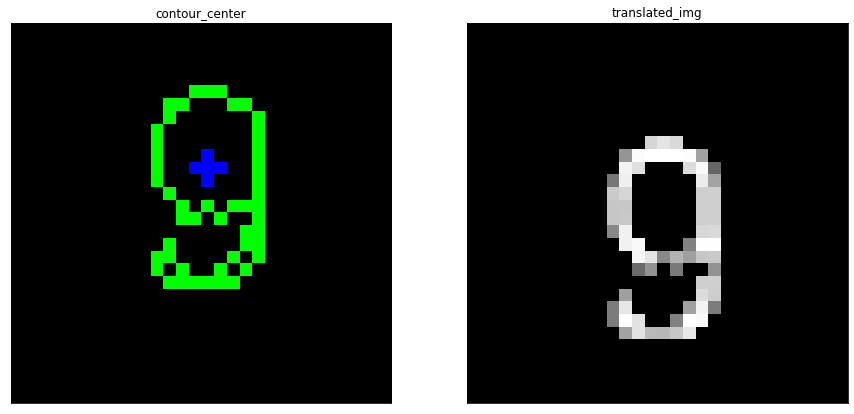

In [310]:
#try moving the largest contour to the center of image
print(thresh_number.shape)
#thresh_number = cv2.cvtColor(thresh_number.copy(),cv2.COLOR_BGR2GRAY)
number_contours,_ = cv2.findContours(thresh_number,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print(len(number_contours))

contour_number_img = np.zeros((thresh_number.shape[0],thresh_number.shape[1],3),np.int32)
sorted(number_contours,key = cv2.contourArea,reverse=True)
contour_number_img = cv2.drawContours(contour_number_img,number_contours,0,(0,255,0),1)
#finding center of mass

largest_contour = number_contours[0]
M = cv2.moments(largest_contour)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
cv2.circle(contour_number_img,(cx,cy),1,(0,0,255),-1)
#plt.imshow(contour_number_img,cmap="gray")

im_cx = im_cy = thresh_number.shape[0]//2
print(im_cx,im_cy)
print(cv2.contourArea(largest_contour))
#translate image
translation_matrix = np.float32([[1,0,(im_cx - cx)],[0,1,im_cy - cy]])
center_number_image = cv2.warpAffine(thresh_number,translation_matrix,thresh_number.shape)
# center_number_image = cv2.GaussianBlur(center_number_image,(3,3),0)
# _,center_number_image = cv2.threshold(center_number_image,60,255,cv2.THRESH_BINARY)
plot_images(contour_number_img,center_number_image,"contour_center","translated_img",figure_size=[15,15])

In [311]:
import pytesseract
pytesseract.image_to_string(cv2.bitwise_not(center_number_image),lang="eng",config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')

'\x0c'

'3\n\x0c'

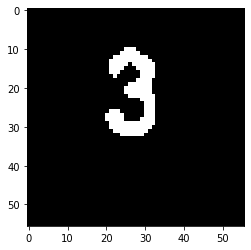

In [120]:
#trying to remove smaller
_,thresh_number = cv2.threshold(number_tiles[66],100,255,cv2.THRESH_BINARY)
plt.imshow(thresh_number,cmap="gray")
num = pytesseract.image_to_string(cv2.bitwise_not(thresh_number),lang="eng",config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
num 

hellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohello

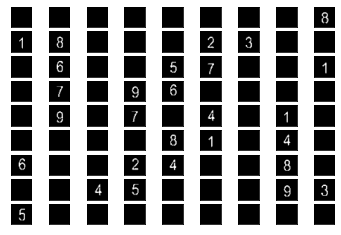

In [284]:
#preprocess images to center

processed_numbers = []
num_kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)

for number_img in number_tiles:
    num = cv2.resize(number_img,(30,30))
    num = cv2.cvtColor(num,cv2.COLOR_BGR2GRAY)
    #num = cv2.medianBlur(num,1)
    _,thresh_num = cv2.threshold(num,100,255,cv2.THRESH_TOZERO)
    # thresh_num = cv2.erode(thresh_num,num_kernel,iterations=1)
    # p = cv2.GaussianBlur(thresh_num,(3,3),0)
    # thresh_num = p
    num_contours,_ = cv2.findContours(thresh_num,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    result_img = np.zeros(thresh_num.shape,np.uint8)
    if(len(num_contours)>=1):
        sorted(num_contours,key=cv2.contourArea,reverse=True)
        largest_contour = num_contours[0]
        if(cv2.contourArea(largest_contour)>=1):
            #creating mask for the ROI
            mask = np.zeros(thresh_num.shape,np.uint8)
            cv2.drawContours(mask,[largest_contour],0,1,-1)
            result_img = cv2.bitwise_and(thresh_num,thresh_num,mask=mask)
            #center the image
            M = cv2.moments(largest_contour)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            im_cx = im_cy = num.shape[0]//2
            print("hello",end="")
            translation_matrix = np.float32([[1,0,(im_cx - cx)],[0,1,im_cy - cy]])
            centered_img = cv2.warpAffine(result_img,translation_matrix,num.shape)
            #centered_img = cv2.GaussianBlur(centered_img,(3,3),0)
            #_,centered_img = cv2.threshold(centered_img,60,255,cv2.THRESH_BINARY)
            result_img = centered_img
    
    processed_numbers.append(result_img)
        


np.shape(processed_numbers)
print_num_grid(9,9,processed_numbers)

In [285]:
import pytesseract
pytesseract.image_to_string(cv2.bitwise_not(processed_numbers[9]),lang="eng",config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')

'1\n\x0c'

In [286]:


digits = []
for number_img in processed_numbers:
    #number_img = cv2.resize(number_img,(28,28))
    #_,thresh_number = cv2.threshold(number_img,150,255,cv2.THRESH_BINARY)
    num = pytesseract.image_to_string(cv2.bitwise_not(number_img),lang="eng",config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
    digits.append(num)


In [287]:
digit_values = []

for digit_text in digits:
    if digit_text[0].isdigit() == True:
        digit_values.append(int(digit_text[0]))
    else:
        digit_values.append(0)

sudoku_matrix = np.reshape(np.array(digit_values,np.int),(-1,9))
sudoku_matrix


array([[0, 0, 0, 0, 0, 0, 0, 0, 8],
       [1, 8, 0, 0, 0, 2, 3, 0, 0],
       [0, 6, 0, 0, 5, 7, 0, 0, 4],
       [0, 7, 0, 9, 6, 0, 0, 0, 0],
       [0, 0, 0, 7, 0, 4, 0, 1, 0],
       [0, 0, 0, 0, 8, 4, 0, 4, 0],
       [6, 0, 0, 2, 4, 0, 0, 8, 0],
       [0, 0, 4, 5, 0, 0, 0, 9, 3],
       [5, 0, 0, 0, 0, 0, 0, 0, 0]])